### Notes:
    - Arity in the grammar is just how many non-terminals are there in the production rule
    ['X8', 'terminal', 0, 7, False, 1] - ['token name', 'token_type', 'Arity', 'col num in the body', 'RecursiveBool', 'min depth to terminate PR rule - smallest tree that cab be made from that PR rule']

    - remainders and possible choices are for the mapping process in the production rules, possible choices % value = remainders

In [1]:
import textwrap
import random
import json
from os.path import join
import grape
import algorithms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools
import warnings

warnings.filterwarnings("ignore")

### Generate weights and dump to json file

In [2]:
# ''.join(['<bit>' for i in range(1, n_items+1)])

In [8]:
# # generate weights for knapsack
# n_items = 100
# items = {f'{i}': {'value': random.randint(
#     1, 20), 'weight': random.randint(1, 100)} for i in range(1, n_items+1)}

# with open("./knapsack-data/knapsackWeights.json", "w") as file:
#     json.dump(items, file)

### Load saved weights

In [9]:
meta_file_path = "./knapsack-data/knapsackWeights.json"
with open(meta_file_path) as file:
    items = json.load(file)

In [10]:
GRAMMAR_FILE = 'knapsack.bnf'
BNF_GRAMMAR = grape.Grammar(
    join("./grammars", GRAMMAR_FILE))

### Check knapsack statistics

In [11]:
sum_weights = 0
sum_values = 0
for k in items:
    sum_values += items[k]['value']
    sum_weights += items[k]['weight']

print(f"Sum of all weights: {sum_weights}")
print(f"Sum of all values: {sum_values}")

Sum of all weights: 5153
Sum of all values: 1092


In [12]:
weight_threshold = int(input("Weight Threshold: "))
print(weight_threshold)

3500


### Best Solution using Dynamic programming

In [13]:
def knapSack_DP(W, wt, val, n):
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]

    # Build table K[][] in bottom up manner
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1]
                              + K[i-1][w-wt[i-1]],
                              K[i-1][w])
            else:
                K[i][w] = K[i-1][w]

    return K[n][W]

val = [items[k].get('value') for k in items]
wt = [items[k].get('weight') for k in items]
W = weight_threshold
n = len(val)
print(knapSack_DP(W, wt, val, n))

990


In [14]:
def get_sack_meta(phenotype):
    value, weight = 0, 0
    for i, bit in enumerate(phenotype):
        value += int(bit) * items[f'{i+1}'].get('value')
        weight += int(bit) * items[f'{i+1}'].get('weight')
    return value, weight

def fitness_eval(individual, points=None):
    if individual.invalid == True:
        return np.NaN,
    if individual.phenotype is None:
        return np.NaN,
    value, weight = get_sack_meta(individual.phenotype)
    if weight >= weight_threshold:
        return np.NaN,
    else:
        fitness = -value
        return fitness,

In [15]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))


# creator.create('Individual', grape.Individual, fitness=creator.FitnessMax)
creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator",
                 grape.sensible_initialisation, creator.Individual)
# toolbox.register("populationCreator",
#                  grape.PI_Grow, creator.Individual)


toolbox.register("evaluate", fitness_eval)  # , points=[X_train, Y_train])

# Tournament selection:
toolbox.register("select", tools.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", grape.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", grape.mutation_int_flip_per_codon)

In [28]:

N_RUNS = 32
POPULATION_SIZE = 200
MAX_GENERATIONS = 300
P_CROSSOVER = 0.9
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

# INIT_GENOME_LENGTH = 30 #used only for random initialisation
# random_initilisation = False #put True if you use random initialisation

MAX_INIT_TREE_DEPTH = 7
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 11
MAX_WRAPS = 0
CODON_SIZE = 255

maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

In [29]:
population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                       w_threshold=weight_threshold,
                                       meta_file_path=meta_file_path,
                                       bnf_grammar=BNF_GRAMMAR,
                                       min_init_depth=MIN_INIT_TREE_DEPTH,
                                       max_init_depth=MAX_INIT_TREE_DEPTH,
                                       codon_size=CODON_SIZE)   

In [30]:
max_value = 0
for ind in population:
    ind_string = ind.phenotype
    value, weight = get_sack_meta(ind.phenotype)
    if weight > weight_threshold:
        print("Warning", "\tIndividual: ", ind_string, "\t Weight", weight, "\t Value", value, "\tLen:", len(ind_string))
    else:
        print("Individual: ", ind_string, "\t Weight", weight, "\t Value", value,"\tLen:", len(ind_string))
    if value > max_value and weight <= weight_threshold:
        max_value = value
        best_weight = weight
        best_ind = ind_string
print("Best individual", best_ind, "\tMax Value", max_value, "\t Best Weight", best_weight)

Individual:  1111000001111100110100110111111100001110001001111000101111111001000110101110001111000100100011111001 	 Weight 2958 	 Value 624 	Len: 100
Individual:  0110000001111010111110010110010011100001001011001010000001101101110001110001110110101001100011101111 	 Weight 2794 	 Value 546 	Len: 100
Individual:  0001001110110001010101100010110011001001101110011101011011111110100111100011011110100010100011100001 	 Weight 2694 	 Value 578 	Len: 100
Individual:  0011011111110000111000000100111110110011110001101010101001100010101101101100001011011011111111010100 	 Weight 2798 	 Value 622 	Len: 100
Individual:  1011100000010001000000010111001111001110011000110100001000011000001111010100010011010000101010000110 	 Weight 1954 	 Value 448 	Len: 100
Individual:  1111110110001001110111010101100001111111011101000011011000101011100011100110000111101001000110101000 	 Weight 2666 	 Value 628 	Len: 100
Individual:  010001010000001100001011101000100101101111101011101110011101010011011000010101111011110

In [31]:
for r in range(0, N_RUNS):
    print("\n\nRun:", r+1, "\n")

    # create initial population (generation 0):
    population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                           w_threshold=weight_threshold,
                                           meta_file_path=meta_file_path,
                                           bnf_grammar=BNF_GRAMMAR,
                                           min_init_depth=MIN_INIT_TREE_DEPTH,
                                           max_init_depth=MAX_INIT_TREE_DEPTH,
                                           codon_size=CODON_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(ELITE_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.nanmean)
    stats.register("std", np.nanstd)
    stats.register("min", np.nanmin)
    stats.register("max", np.nanmax)

    # perform the Grammatical Evolution flow:
    population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                            ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                            bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE,
                                                            max_tree_depth=MAX_TREE_DEPTH,
                                                            points_train=None,
                                                            stats=stats, halloffame=hof, verbose=True)

    best = hof.items[0].phenotype  # parser to change the individual
    print("Best individual: \n", "\n".join(textwrap.wrap(best, 80)))
    print("\nFitness: ", -hof.items[0].fitness.values[0])
    # sack_weight = 0
    # for i, ch in enumerate(best):
    #     sack_weight += int(ch) * items[str(i+1)][1]
    # print("\nWeight: ", sack_weight)
    _, weight = get_sack_meta(best)
    print("\nWeight: ", weight)
    print("Depth: ", hof.items[0].depth)
    print("Length of the genome: ", len(hof.items[0].genome))
    print(
        f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

    max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
    min_fitness_values, std_fitness_values = logbook.select("min", "std")
    best_ind_length = logbook.select("best_ind_length")
    avg_length = logbook.select("avg_length")

    selection_time = logbook.select("selection_time")
    generation_time = logbook.select("generation_time")
    gen, invalid = logbook.select("gen", "invalid")
    avg_used_codons = logbook.select("avg_used_codons")
    best_ind_used_codons = logbook.select("best_ind_used_codons")

    best_ind_nodes = logbook.select("best_ind_nodes")
    avg_nodes = logbook.select("avg_nodes")

    # structural_diversity = logbook.select("structural_diversity")

    best_ind_depth = logbook.select("best_ind_depth")
    avg_depth = logbook.select("avg_depth")

    fitness_test = logbook.select("fitness_test")
    max_length = logbook.select("max_length")

    # Save statistics for this run:
    avgListFitness.append(mean_fitness_values)
    stdListFitness.append(std_fitness_values)
    minListFitness.append(min_fitness_values)
    maxListFitness.append(max_fitness_values)

    # avgListSize.append(avg_depth)
    # stdListSize.append(stdSizeValues)
    # minListSize.append(minSizeValues)
    # maxListSize.append(maxSizeValues)




Run: 1 

gen	invalid	avg    	std    	min 	max 	best_ind_length	avg_length	best_ind_nodes	avg_nodes	best_ind_depth	avg_depth	avg_used_codons	best_ind_used_codons	structural_diversity	selection_time	generation_time
0  	0      	-537.85	60.3889	-720	-391	151            	151       	100           	100      	3             	3        	101            	101                 	1                   	0             	0.0368564      
1  	23     	-584.181	57.164 	-733	-415	187            	160.085   	100           	100      	3             	3        	101            	101                 	0.875               	0.00125837    	0.117076       
2  	33     	-608.778	51.7689	-733	-474	187            	168.563   	100           	100      	3             	3        	101            	101                 	0.82                	0.000655413   	0.113264       
3  	39     	-627.465	53.4409	-744	-495	128            	169.082   	100           	100      	3             	3        	101            	101                 	0.79              

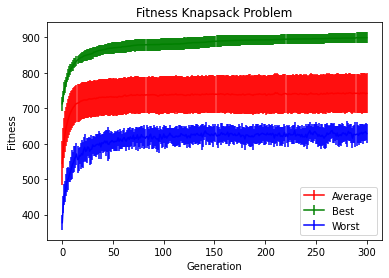

In [32]:
#plot statistics:
x = np.arange(0, MAX_GENERATIONS+1)
avgArray = np.array(avgListFitness)
stdArray = np.array(stdListFitness)
minArray = np.array(minListFitness)
maxArray = np.array(maxListFitness)

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Knapsack Problem')
plt.errorbar(x, -avgArray.mean(0), yerr=-stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, -minArray.mean(0), yerr=-minArray.std(0),label="Best", color="Green")
plt.errorbar(x, -maxArray.mean(0), yerr=-maxArray.std(0),label="Worst", color="Blue")
# plt.xlim([0, 20])
plt.legend()
plt.show()

In [33]:
print("Best fitness achieved", -np.min(minArray))

Best fitness achieved 937.0


In [ ]:
# #plot statistics:
# x = np.arange(0, MAX_GENERATIONS+1)
# avgArray = np.array(avgListFitness)
# stdArray = np.array(stdListFitness)
# minArray = np.array(minListFitness)
# maxArray = np.array(maxListFitness)

# plt.xlabel('Generation')
# plt.ylabel('Fitness')
# plt.title('Fitness Knapsack Problem')
# plt.errorbar(x, -avgArray.mean(0), yerr=-stdArray.mean(0),label="Average",color="Red")
# plt.errorbar(x, -minArray.mean(0), yerr=-minArray.std(0),label="Best", color="Green")
# plt.errorbar(x, -maxArray.mean(0), yerr=-maxArray.std(0),label="Worst", color="Blue")
# # plt.xlim([0, 20])
# plt.legend()
# plt.show()

In [ ]:
# x = np.arange(0, MAX_GENERATIONS+1)
# avgSizeArray = np.array(avgListSize)
# bestSizeArray = np.array(bestListSize)
# maxSizeArray = np.array(maxListSize)


# plt.errorbar(x, avgSizeArray.mean(0), yerr=avgSizeArray.std(0),label="Average",color="Red")
# # plt.errorbar(x, maxSizeArray.mean(0), yerr=maxSizeArray.std(0), label="Max", color="Green")
# plt.errorbar(x, bestSizeArray.mean(0), yerr=bestSizeArray.std(0), label="Best", color="Blue")
# plt.legend(fontsize=12)
# plt.xlabel('Generations', fontsize=14)
# plt.ylabel('Genome Length', fontsize=14)
# plt.title('Length over Generations', fontsize=16)
# plt.legend()
# plt.xlim([0, 30])
# plt.ylim([5, 50])
# plt.show()